# NianticLabs MonoDepth2

[Monodepth2](https://github.com/nianticlabs/monodepth2) is the reference PyTorch implementation for training and testing depth estimation models using the method described in:

> **Digging into Self-Supervised Monocular Depth Prediction**
>
> [Clément Godard](http://www0.cs.ucl.ac.uk/staff/C.Godard/), [Oisin Mac Aodha](http://vision.caltech.edu/~macaodha/), [Michael Firman](http://www.michaelfirman.co.uk) and [Gabriel J. Brostow](http://www0.cs.ucl.ac.uk/staff/g.brostow/)
>
> [ICCV 2019 (arXiv pdf)](https://arxiv.org/abs/1806.01260)


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

from utils.helper import download_model_if_doesnt_exist, ResnetEncoder, DepthDecoder

## Load Model and Weights

In [ ]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = ResnetEncoder(18, False)
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Load a Test Image

In [7]:
image_path = "../assets/imgs/mcrn.jpg"

input_image = Image.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), Image.Resampling.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Run Predictions

In [8]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disparity = outputs[("disp", 0)]

disparity_resized = torch.nn.functional.interpolate(disparity,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disparity_resized_np = disparity_resized.squeeze().cpu().numpy()
vmax = np.percentile(disparity_resized_np, 95)

(-0.5, 999.5, 666.5, -0.5)

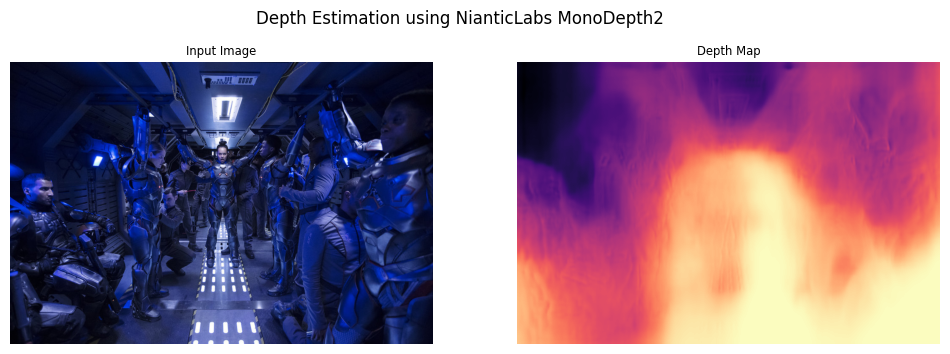

In [9]:
plt.figure(figsize=(12, 4))
plt.suptitle('Depth Estimation using NianticLabs MonoDepth2')

ax = plt.subplot(1, 2, 1)
img_title = 'Input Image'
plt.imshow(input_image)
plt.title(img_title, fontsize='small')
plt.axis(False)

ax = plt.subplot(1, 2, 2)
img_title = 'Depth Map'
plt.imshow(disparity_resized_np, cmap='magma', vmax=vmax)
plt.title(img_title, fontsize='small')
plt.axis(False)